In [5]:
import json
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import operator
import os
import pandas as pd
import re

from functools import reduce
from pathlib import Path
from tqdm.auto import tqdm
from typing import Any, Dict, Mapping, Optional, Sequence

import keypoint_moseq as kpms

In [3]:
unsupervised_aging_dir = Path(os.environ["UNSUPERVISED_AGING"])

project_name  = "2025-07-20_kpms-v4_150"
model_name    = "2025-07-20_model-1"
kpms_dir      = unsupervised_aging_dir / "data/kpms_projects"
dataset_dir   = unsupervised_aging_dir / "data/datasets/combined_1126/"
poses_csv_dir = dataset_dir / "poses_csv"

supervised_features_path = unsupervised_aging_dir / "data/archive/B6DO_video.csv"
adj_metadata_path = unsupervised_aging_dir / "data/adj_metadata_sheets/combined_1126_adj_metadata.csv"

project_dir = kpms_dir / project_name

In [26]:
metadata_df = pd.read_csv("/projects/kumar-lab/miaod/projects/unsupervised-aging/data/feature_matrices/2025-07-23_feature-matrix__combined_1126__2025-07-20_kpms-v4_150__2025-07-20_model-1.csv")
metadata_df

,Unnamed: 0,name,mouse_id,sex,batch,tester,age,fi,weight,diet,...,grooming_duration_secs,Rearing_supported_T5,Rearing_supported_T20,Rearing_supported_T55,Rearing_unsupported_T5,Rearing_unsupported_T20,Rearing_unsupported_T55,Grooming_T5,Grooming_T20,Grooming_T55
0,0,LL1-B2B__2019-12-24_SPD__LL1-1_AgedB6-0420,AgedB6-0420,Male,Batch1,Hannah,55.000000,7.287800,49.00,AL,...,68.20147,0.047222,0.059278,0.045596,0.002000,0.002111,0.004485,0.018111,0.014250,0.024364
1,1,LL1-B2B__2020-01-02_SPD__LL1-1_AgedB6-0744,AgedB6-0744,Male,Batch1,Mackenzie,29.000000,4.320384,40.43,AL,...,170.43687,0.088111,0.076472,0.070101,0.011222,0.057806,0.114293,0.022778,0.024194,0.049485
2,2,LL1-B2B__2020-01-02_SPD__LL1-4_AgedB6-0746,AgedB6-0746,Female,Batch1,Mackenzie,28.000000,2.320384,27.53,AL,...,148.81530,0.044444,0.048361,0.045515,0.008111,0.009500,0.015737,0.016556,0.017889,0.018061
3,3,LL1-B2B__2020-06-16_SPD__AgedB6-0411,AgedB6-0411,Female,Batch1,Hannah,80.000000,5.787800,40.01,AL,...,69.73327,0.029667,0.018194,0.031596,0.001333,0.019694,0.024646,0.024778,0.016806,0.016273
4,4,LL1-B2B__2020-06-17_SPD__AgedB6-0420,AgedB6-0420,Male,Batch1,Hannah,80.000000,8.787800,55.85,AL,...,72.26663,0.017667,0.024333,0.028747,0.005333,0.002417,0.005384,0.012333,0.005833,0.017707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1113,1113,Batch2__LL4-B6__2023-07-10_MFS__DO2305_DO_F_25109,DO-2305,Female,New,Sean Deats,25.857143,3.348214,45.21,AL,...,65.20002,0.024556,0.020306,0.016343,0.000556,0.000417,0.000152,0.000000,0.014639,0.016939
1114,1114,Batch2__LL5-B6__2023-07-06_MFS__DO2348_DO_M_25063,DO-2348,Male,New,Sean Deats,25.285714,2.570436,37.13,AL,...,125.46667,0.026333,0.032861,0.070576,0.000000,0.000000,0.001980,0.010778,0.027917,0.047323
1115,1115,Batch2__LL5-B6__2023-07-10_MFS__DO2307_DO_F_25111,DO-2307,Female,New,Sean Deats,25.857143,2.181547,40.38,AL,...,0.00000,0.091000,0.079083,0.064313,0.000000,0.004917,0.004071,0.023778,0.007806,0.108727
1116,1116,Batch2__LL1-B6__2023-07-06_MFS__DO2334_DO_M_25050,DO-2334,Male,New,Sean Deats,25.285714,2.959325,43.94,AL,...,116.33336,0.006333,0.006528,0.004667,0.006333,0.006222,0.004556,0.008111,0.020667,0.013303


In [19]:
results = kpms.load_results(project_dir, model_name)

In [8]:
sequences = [pose_dict["syllable"] for pose_dict in results.values()]
unique_syllables = sorted({s for seq in sequences for s in seq})
print(len(unique_syllables), max(unique_syllables))

94 95


In [20]:
results

{'Batch2__LL1-B6__2023-07-06_MFS__DO2271_DO_F_25075.csv': {'centroid': array([[ -2.71723987,  -1.75747218],
         [ -3.15562213,  -1.63295246],
         [ -2.87520182,  -2.06668537],
         ...,
         [ 54.862812  , 265.50529009],
         [ 54.61459796, 265.63997181],
         [ 55.14210498, 265.43341716]]),
  'heading': array([ 2.543802  , -2.91830394, -2.25458771, ...,  1.29357375,
          1.17486477,  1.18701031]),
  'latent_state': array([[ 4.83181587,  0.3664726 ,  3.01118313, ..., -2.33306229,
           1.78133978, -4.10827095],
         [-1.62503961, -1.89052413, -5.59302276, ...,  0.87566876,
          -1.47684768,  0.95989001],
         [-0.29582902,  2.22781463,  0.6889765 , ...,  1.96974346,
          -0.92262622, -2.53466019],
         ...,
         [-0.42453777,  0.04087843,  0.43979696, ...,  0.41713115,
           0.04844846,  0.04496021],
         [-0.57356241,  0.0795908 ,  0.51197926, ...,  0.27874052,
           0.18296492,  0.15807975],
         [-0.6137

In [32]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, networkx as nx

def plot_transition_graph_by_strain(results, metadata_df, num_syllables=None, min_weight=0.0, width_scale=8.0, group_strength=2.0, seed=0):
    def strain_from_row(r):
        m, n = str(r.get("mouse_id","")), str(r.get("name",""))
        if "DO" in m or "DO" in n: return "DO"
        if "B6" in m or "B6" in n: return "B6"
        return None
    name_to_strain = {str(r["name"]): strain_from_row(r) for _, r in metadata_df.iterrows()}
    def base_name(k): return str(k).rsplit(".",1)[0]
    seqs_B6, seqs_DO = [], []
    for k, v in results.items():
        seq = v.get("syllable", v.get("sylablle"))
        if seq is None or len(seq) < 2: continue
        s = name_to_strain.get(base_name(k))
        if s == "B6": seqs_B6.append(np.asarray(seq, dtype=int))
        elif s == "DO": seqs_DO.append(np.asarray(seq, dtype=int))
    if not seqs_B6 or not seqs_DO:
        raise ValueError(f"Need both B6 and DO sequences. Got B6={len(seqs_B6)}, DO={len(seqs_DO)}.")
    vocab = int(max(int(x.max()) for x in (seqs_B6 + seqs_DO))) + 1
    if num_syllables: vocab = min(vocab, int(num_syllables))
    def T(seqs, V):
        M = np.zeros((V,V), float)
        for s in seqs:
            s = s[s < V]
            if len(s) < 2: continue
            for a,b in zip(s[:-1], s[1:]):
                if a!=b and 0<=a<V and 0<=b<V: M[a,b]+=1
        rs = M.sum(axis=1, keepdims=True)
        np.divide(M, rs, out=M, where=rs!=0)
        return M
    MB6, MDO = T(seqs_B6, vocab), T(seqs_DO, vocab)
    D = MB6 - MDO
    n = D.shape[0]
    G = nx.DiGraph()
    for i in range(n): G.add_node(i)
    edges, colors, widths = [], [], []
    amax = np.max(np.abs(D)) if np.any(D) else 1.0
    for i in range(n):
        for j in range(n):
            if i==j: continue
            w = D[i,j]
            if abs(w) <= min_weight: continue
            edges.append((i,j))
            colors.append("red" if w>0 else "blue")
            widths.append(width_scale*abs(w)/amax)
    node_score = D.sum(0) + D.sum(1)
    b6_nodes = [i for i in range(n) if node_score[i] > 0]
    do_nodes = [i for i in range(n) if node_score[i] <= 0]
    UG = nx.Graph()
    UG.add_nodes_from(range(n))
    for (i,j),w in zip([(i,j) for i in range(n) for j in range(n) if i!=j], [abs(D[i,j]) for i in range(n) for j in range(n) if i!=j]):
        if w>min_weight: UG.add_edge(i,j,weight=w)
    for group in (b6_nodes, do_nodes):
        for i in group:
            for j in group:
                if i<j:
                    w = group_strength*(abs(node_score[i])+abs(node_score[j]))/max(1.0, np.sum(np.abs(node_score)))
                    if w>0: UG.add_edge(i,j,weight=UG[i][j]["weight"]+w if UG.has_edge(i,j) else w)
    rng = np.random.default_rng(seed)
    pos0 = {i: np.array([-1+0.2*rng.standard_normal(), rng.uniform(-1,1)]) for i in b6_nodes}
    pos0.update({i: np.array([+1+0.2*rng.standard_normal(), rng.uniform(-1,1)]) for i in do_nodes})
    pos = nx.spring_layout(UG, weight="weight", seed=seed, pos=pos0, iterations=200)
    fig, ax = plt.subplots(figsize=(9,6))
    nx.draw_networkx_nodes(G, pos, nodelist=b6_nodes, node_size=600, node_color="white", edgecolors="red", ax=ax)
    nx.draw_networkx_nodes(G, pos, nodelist=do_nodes, node_size=600, node_color="white", edgecolors="blue", ax=ax)
    nx.draw_networkx_labels(G, pos, labels={i:str(i) for i in range(n)}, font_size=10, ax=ax)
    if edges:
        nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=colors, width=widths, alpha=0.85, arrows=True, arrowsize=10, ax=ax)
    from matplotlib.lines import Line2D
    ax.legend([Line2D([0],[0], color="red", lw=3), Line2D([0],[0], color="blue", lw=3)], ["higher in B6","higher in DO"], loc="lower center", bbox_to_anchor=(0.5,-0.08))
    ax.axis("off")
    fig.tight_layout()
    plt.show()


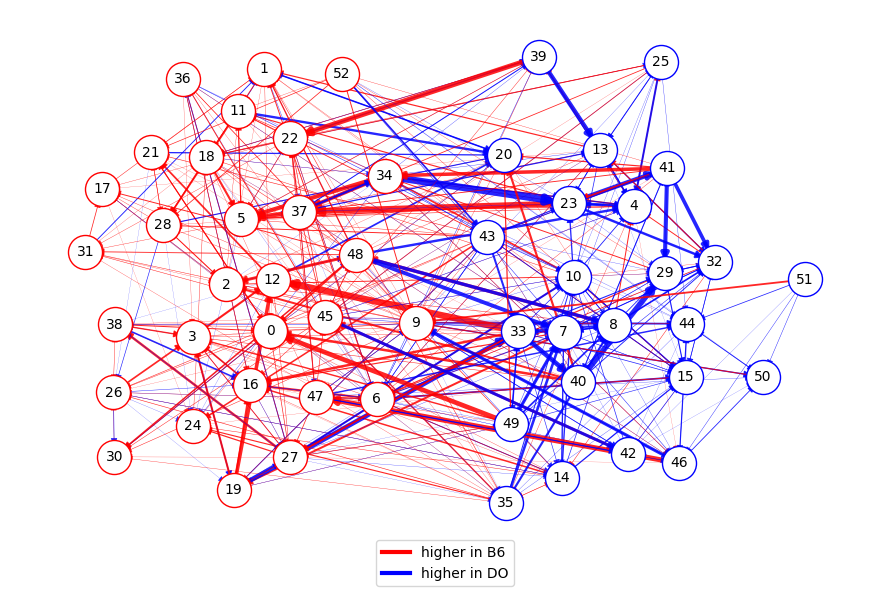

In [36]:
plot_transition_graph_by_strain(results, metadata_df, num_syllables=53, min_weight=0.01, width_scale=5.0)
